# Машинное обучение, DS-поток, осень 2024
## Задание ML.11

Задача 1: Transfer learning.
▫️ Пункт 2: наличие решения. (90.0)
▫️ Пункт 2. Нет сравнения моделей. (-10.0)
▫️ Пункт 3: наличие решения. (45.0)
▫️ Пункт 4: наличие решения. (45.0)
▫️ Пункт 5: наличие решения. (10.0)
Баллы: 180.0 / 190.0

Сумма: 180.0 / 190.0

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install torchmetrics

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from shutil import copyfile, copytree
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision.models import resnet50
from torchmetrics.classification import MulticlassF1Score as F1

import wandb
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

In [6]:
sns.set(style='darkgrid', palette='Set2')
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### 0. Инструкция Pytorch Lightning + WandB

Это задание нужно выполнять, используя Pytorch Lightning совместно с WandB.

1. Обучение каждой из моделей должно идти с отдельным запуском в WandB. Если вы закончили всю работу с данной моделью (включая тестирование), не забывайте завершать запуск с помощью `wandb.finish()`.


2. **Важно**: Делать скрины с [wandb.ai](https://wandb.ai) и вставлять ссылки на [wandb.ai](https://wandb.ai) крайне не приветствуется и может караться. Не создавайте ссылок на ваш проект &mdash; он должен быть приватным! Вместо этого, смотрите пункт [Визуализация запусков и выводы](#vis).

3. Если вы сделали задание только частично, все равно визуализируйте имеющиеся запуски в пункте [Визуализация запусков и выводы](#vis).





## Задача 1. Transfer learning
Вы научите нейронную сеть классифицировать произведения искусства различных художников, т.е. определять к какому художнику относится картина.

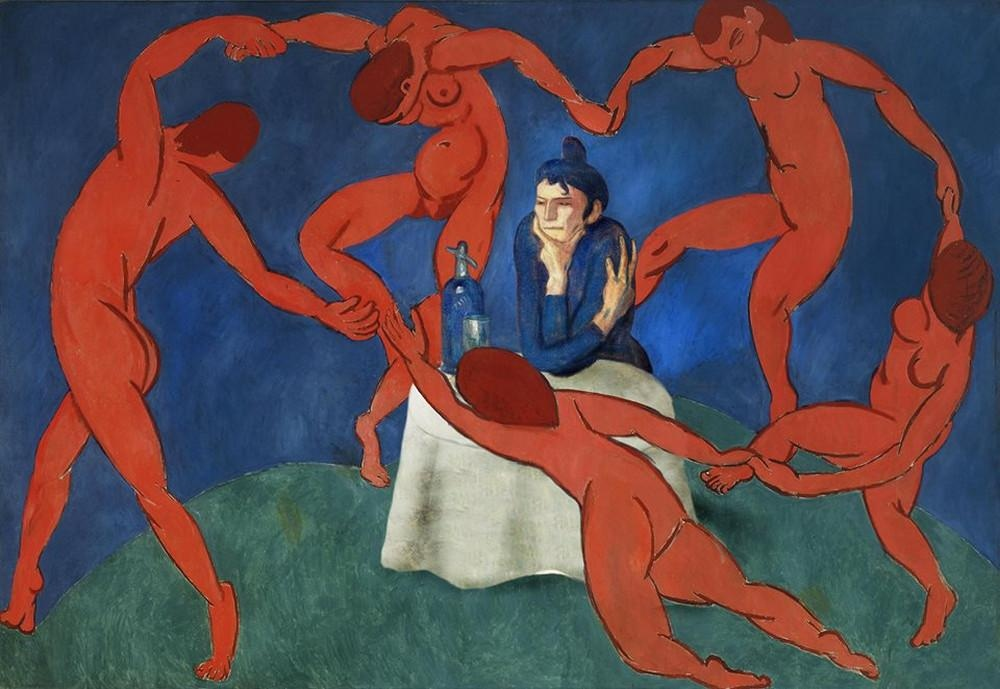

### 1. Данные
Скачайте архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Если вы работаете в **Google Colab**, то удобнее всего будет скачать архив на Google Drive (диск). В таком случае не придестя загружать архив вручную каждый раз, когда обрывается runtime. Для этого перейдите в левую  боковую панель, нажмите на кнопку с папочкой, а затем на кнопку с папочкой с изображением Google Drive. Теперь все файлы с диска доступны по пути `drive/MyDrive/`.

Если вы работаете в **Kaggle**, то для того, чтобы загрузить данные, перейдите в правую боковую панель. В разделе `Data` возле кнопки `Add Data` расположена кнопка загрузки данных. Нажмите на нее, появится панель `Create a New Dataset`. Назовите новый датасет. Загрузите туда архив.  После того, как датасет будет проверен, он повится у вас в датасетах. Для того, чтобы начать с ним работать в ноутбуке в Kaggle нужно снова перейти в раздел `Data` и нажать `Add Data`. Затем нажмите кнопку `Your Datasets` и нажмите на плюс возле вашего датасета. После этго датасет появится в а разделе `Data`. Причем **Kaggle** разархивирует данные за вас.

Для того, чтобы разархивировать данные, выполните следующие действия.

In [14]:
# Запишите путь до архива.
zip_path = '/content/drive/MyDrive/Colab Notebooks/artworks.zip'
# Замените пробелы в пути, чтобы следующая bash-команда работала корректно.
zip_path_bash = str(zip_path).replace(' ', '\ ')
# Разархивируйте файлы.
!unzip $zip_path_bash -d .
# Укажите путь до данных.
data_path = Path('./artworks')

Archive:  /content/drive/MyDrive/Colab Notebooks/artworks.zip
replace ./artworks/artists.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
data_path = Path('/content/drive/MyDrive/Colab Notebooks/artworks')

Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [ ]:
sorted((data_path / 'images' / 'train').iterdir())

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [ ]:
sorted((data_path / 'images' / 'train' / 'Albrecht_Durer').iterdir())

Приведем примеры изображений.

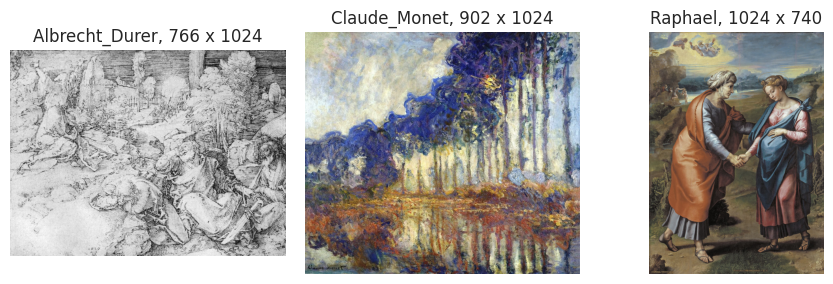

In [10]:
images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg'
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Заметьте, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации, см. пример с Симпсонами в семинаре.


Теперь посмотрим на таблицу с характеристиками художников.



In [11]:
df = pd.read_csv(data_path / 'artists.csv')

Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого худодника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

In [12]:
df[df.paintings >= 200]

,name,years,genre,nationality,bio,wikipedia,paintings
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
22,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


Для обучения вам понадобится построить датасет. Удобнее всего будет воспользоваться `torchvision.datasets.ImageFolder`, см. пример в семинаре с Симпсонами.

In [13]:
names_200 = df[df.paintings >= 200].name.replace({' ' : '_', 'ü' : 'u'}, regex=True).to_list()

!mkdir artworks200
!mkdir artworks200/train
!mkdir artworks200/test

data_200 = Path('artworks200')

for name in names_200:
    copytree(data_path / 'images' / 'train' / name, data_200 / 'train' / name, dirs_exist_ok=True)
    copytree(data_path / 'images' / 'test' / name, data_200 / 'test' / name, dirs_exist_ok=True)

In [14]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dir = data_200 / 'train'
test_dir = data_200 / 'test'

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    test_dir,
    transform=val_transform
)

In [15]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 3004
    Root location: artworks200/train
    StandardTransform
Transform: Compose(
               Resize(size=200, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(200, 200))
               ToTensor()
           )

In [16]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1295
    Root location: artworks200/test
    StandardTransform
Transform: Compose(
               Resize(size=200, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(200, 200))
               ToTensor()
           )

In [17]:
batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 2. Fine-tuning
Выберите одну из моделей [здесь](https://pytorch.org/vision/stable/models.html) для fine-tuning, архитектуру которой мы разбирали на лекции. Поясните свой выбор.

**Ответ:**
Возьмем ResNet50. Она небольшого размера, поэтому будет быстрее обучаться. Также у нее неплохое качество на ImageNet

Как вы думаете, какой вариант fine-tuning больше подходит для данной задачи?

**Ответ:**
Наш датасет довольно специфический, поэтому возможно стоит разморозить и сверточные слои тоже.

Создадим класс модели для Pytorch Lightning:

In [18]:
class FineTunedNet(LightningModule):
    def __init__(self, to_freeze, n_classes, lr, weight=None):
        '''Инициализация модели
        * to_freeze -- сколько слоев хотим заморозить.
        * n_classes -- кол-во классов'''

        super().__init__()

        backbone = resnet50(weights='ResNet50_Weights.DEFAULT')
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        for i, param in enumerate(self.feature_extractor.parameters()):
            param.requires_grad = False
            if i == to_freeze-1:
                break

        self.n_classes = n_classes
        self.weight = weight
        self.criterion = nn.CrossEntropyLoss(self.weight)
        self.lr = lr
        self.f1 = F1(num_classes=self.n_classes, average='macro')
        self.save_hyperparameters()

        self.classifier = nn.Sequential()
        self.classifier.add_module('relu_1', nn.ReLU())
        self.classifier.add_module('fc_1', nn.Linear(num_filters, 512))
        self.classifier.add_module('relu_2', nn.ReLU())
        self.classifier.add_module('fc_2', nn.Linear(512, self.n_classes))

    # Много разных методов: forward, configure_optimizers, training_step,
    # validation_step, on_train_epoch_end, on_validation_epoch_end, и т.д.

    def forward(self, x):
        '''Forward pass'''

        representations = self.feature_extractor(x).flatten(1)
        out = self.classifier(representations)
        return out

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        preds, loss = self.__get_preds_loss(batch)

        # Логируем лосс
        self.log('train_loss', loss, on_step=True)
        self.train_epoch_preds.append(preds)
        self.train_epoch_y.append(batch[1])

        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss = self.__get_preds_loss(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss, on_step=True, on_epoch=False)
        self.val_epoch_preds.append(preds)
        self.val_epoch_y.append(batch[1])
        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def on_train_epoch_start(self):
        self.train_epoch_preds = []
        self.train_epoch_y = []

    def on_validation_epoch_start(self):
        self.val_epoch_preds = []
        self.val_epoch_y = []

    def on_train_epoch_end(self):
        self.train_epoch_preds = torch.cat(self.train_epoch_preds)
        self.train_epoch_y = torch.cat(self.train_epoch_y)

        metric = self.__get_metric(self.train_epoch_preds, self.train_epoch_y)

        self.log('training epoch F1_macro', metric)

    def on_validation_epoch_end(self):
        self.val_epoch_preds = torch.cat(self.val_epoch_preds)
        self.val_epoch_y = torch.cat(self.val_epoch_y)

        metric = self.__get_metric(self.val_epoch_preds, self.val_epoch_y)

        self.log('validation epoch F1_macro', metric)

    def test_step(self, batch, batch_idx=0):
        '''Используется для логирования метрик'''
        preds, loss = self.__get_preds_loss(batch)

        idx = (batch[1] == self.unpopular_classes[:, None]).any(axis=0)
        preds = preds
        self.test_epoch_preds.append(preds[idx])
        self.test_epoch_y.append(batch[1][idx])
        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def on_test_epoch_start(self):
        self.test_epoch_preds = []
        self.test_epoch_y = []

    def on_test_epoch_end(self):
        self.test_epoch_preds = torch.cat(self.test_epoch_preds)
        self.test_epoch_y = torch.cat(self.test_epoch_y)

        metric = self.__get_metric(self.test_epoch_preds, self.test_epoch_y)

        self.log('test epoch F1_macro', metric)

    def test_dataloader(self):
        return validation_loader


    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)

        return preds, loss

    def __get_metric(self, preds, y):
        metric = self.f1(preds, y).to(self.device)

        return metric

Попробуйте fine-tuning с разным количеством размороженных слоев, достаточно трех вариантов. Сравните ошибку (лосс) и качество (F1 macro) на тренировочной и тестовой частях выборки во время обучения. F1 Score считайте не на каждом батче, а на всей эпохе. Для этого можно воспользоваться методами `on_train_epoch_end` и `on_validation_epoch_end`.

Всего в сети 160 параметров (model.parameters()), будем заморживать первые 25%, 50%, 75%

In [19]:
model = FineTunedNet(40, len(df[df.paintings >= 200]), lr=1e-3)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Artist Recognition"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, training_loader, validation_loader)
wandb.finish()

wandb: Currently logged in as: rusinovadi004 (rusinovadi004-mipt). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
----------------------------------------------------------------
24.1 M    Trainable params
471 K     Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████████
train_loss,█▄▄▄▄▃▃▃▂▂▂▂▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▁▁▁▁▃▃▃▃▄▂▂▂▂▄▅▅▂▃▃▃▅▆▆▆▆▆▇▃▃▃▃▇███▄
training epoch F1_macro,▁▆▇██
val_loss,▂▅▃█▇▅▃▂▁▃▅▅▃▅▂▄▃▃▂▃▂▄▄▄▂▂▃▄▃▄▂▂▂▃▃▂▂▃▂▃
validation epoch F1_macro,▁▅▃█▇
epoch,4
train_loss,0.13399
trainer/global_step,234
training epoch F1_macro,0.96126
val_loss,0.62634


In [21]:
model = FineTunedNet(80, len(df[df.paintings >= 200]), lr=1e-3)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Simpsons"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, training_loader, validation_loader)
torch.save(model.state_dict(), 'model050.pth')
wandb.finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
----------------------------------------------------------------
22.1 M    Trainable params
2.4 M     Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█████████
train_loss,█▆▆▅▅▃▄▃▃▅▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▃▁▁▁▁▂▁▁▁▁▁▂▂▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▁▁▃▃▄▂▂▄▄▄▄▄▄▅▅▅▃▃▆▆▆▆▇▃▃▃▇████▄
training epoch F1_macro,▁▇███
val_loss,▂▁▃▃▂▃▃▄▂▂▂▁▂▃▄█▃▃▃▁▃▂▂▂▁▆▃▁▁▄▃▂▂▃▂▃▅▂▃▂
validation epoch F1_macro,▇▂▇▁█
epoch,4
train_loss,0.02907
trainer/global_step,234
training epoch F1_macro,0.96452
val_loss,0.3458


In [23]:
model = FineTunedNet(120, len(df[df.paintings >= 200]), lr=1e-3)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Simpsons"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, training_loader, validation_loader)
torch.save(model.state_dict(), 'mode075.pth')
wandb.finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
----------------------------------------------------------------
17.1 M    Trainable params
7.4 M     Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆████████████
train_loss,█▆▅▄▄▄▂▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▁▂▃▃▃▃▂▂▄▅▅▅▅▅▃▃▃▃▅▆▇▇▃▃▃▃▃▇▇███▄▄
training epoch F1_macro,▁▆███
val_loss,▂▁▂▃▆▁▂▂▃▁▂▅▄▁▂▁▁▂▄▂▃▂▂▁▂▃▄▄▄▄▃▂▂▃▅▆▅▂██
validation epoch F1_macro,▃▃▁█▃
epoch,4
train_loss,0.07603
trainer/global_step,234
training epoch F1_macro,0.98716
val_loss,1.36607


Поясните, в чем преимущества F1 macro по сравнению с accuracy. Сделайте выводы.

**Вывод:**
Accuracy просто измеряет долю правильно классифицированных примеров, не обращая внимания на то, какие классы преобладают. В задачах с несбалансированными данными она может быть высокой за счет правильной классификации более частого класса, игнорируя редкие.
F1 macro, наоборот, учитывает precision (точность предсказаний для каждого класса) и recall (полноту для каждого класса). Это делает его более чувствительным к качеству классификации редких классов.

### 3. Аугментации

Для улучшения качества модели можно расширить обучающую выборку. Это можно сделать с помощью аугментации данных. Подумайте, какие аугментации здесь будут полезны, напишите свой ответ.

transforms.ColorJitter(0.9, 0.9, 0.9)
Картины разных художников могут иметь различия в цветах, освещении и оттенках.
Эта аугментация помогает модели научиться фокусироваться не на абсолютных цветах, а на важных особенностях стиля (например, мазки кисти, текстура).


Аффинные преобразования помогают модели сосредоточиться на ключевых особенностях стиля художников, игнорируя шумовые факторы (небольшие искажения, наклоны)



**Ответ:**

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [25]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.RandomAffine(degrees=5),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dir = data_200 / 'train'
test_dir = data_200 / 'test'

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    test_dir,
    transform=val_transform
)

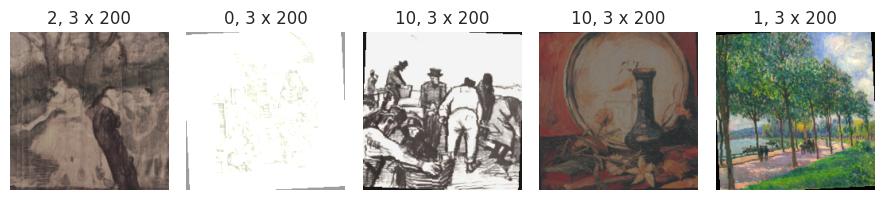

In [28]:
plt.figure(figsize=(9, 3))
idx = np.random.randint(0, 3000, size=(5,))
for i, iid in enumerate(idx):
    author = train_dataset[iid][1]
    plt.subplot(1, 5, i + 1)
    image = train_dataset[iid][0]
    plt.imshow(image.movedim(0, -1))
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Выберите лучшую модель. Примените fine-tining модели
 на аугментированных данных. Получается ли улучшить качество?

In [29]:
batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
model = FineTunedNet(120, len(df[df.paintings >= 200]), lr=1e-3)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Simpsons"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model, training_loader, validation_loader)
torch.save(model.state_dict(), 'mode075.pth')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
----------------------------------------------------------------
17.1 M    Trainable params
7.4 M     Non-trainable params
24.6 M    Total params
98.251    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


**Вывод:**

Аугментация данных делает модель более гибкой и точной, помогая ей лучше различать стили и детали, характерные для каждого художника. Качество улучшилось на 0.02.

### 4. Несбалансированность классов
Расширим выборку до всех классов. Примените fine-tuning для расширенной выборки. Хорошо ли модель предсказывает малопредставленные классы?

Для подсчета F1 Score на редких классах после обучения определите у модели метод `test_step` и запустите `trainer.test(model, ...)` (до завершения запуска WandB!). На тесте разрешается записывать метки / предсказания в поля класса.

In [32]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.RandomAffine(degrees=5),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dir = data_path / 'images' / 'train'
test_dir = data_path / 'images' / 'test'

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    test_dir,
    transform=val_transform
)

In [33]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 5888
    Root location: /content/drive/MyDrive/Colab Notebooks/artworks/images/train
    StandardTransform
Transform: Compose(
               Resize(size=200, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(200, 200))
               RandomAffine(degrees=[-5.0, 5.0])
               ColorJitter(brightness=(0.09999999999999998, 1.9), contrast=(0.09999999999999998, 1.9), saturation=(0.09999999999999998, 1.9), hue=None)
               ToTensor()
           )

In [34]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 2558
    Root location: /content/drive/MyDrive/Colab Notebooks/artworks/images/test
    StandardTransform
Transform: Compose(
               Resize(size=200, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(200, 200))
               ToTensor()
           )

В качестве решения проблемы несбалансированности классов можно взвешивать лосс. Если это [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), то можно указать в параметре `weight` веса классов. Также можно поменять стратегию семплирования при обучении, для этого можно использовать [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) в качестве параметра `sampler` в `dataloader`. Подумайте, как еще можно можно решить эту проблему. Попробуйте одну из стратегий. Получается ли улучшить качество?

In [35]:
batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
model = FineTunedNet(120, len(df), lr=1e-3)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Simpsons"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, training_loader, validation_loader)
torch.save(model.state_dict(), 'mode075.pth')

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./Artist Recognition/z7fcigto/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
-----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [39]:
lst_unp = df[df.paintings < 200].name.replace({' ' : '_'}, regex=True).to_list()
df_unp = pd.DataFrame(train_dataset.class_to_idx, index=[0])
FineTunedNet.unpopular_classes = torch.tensor(([df_unp[lst_unp[i]].to_numpy().item() for i in range(len(lst_unp))])).to('cuda')

In [40]:
trainer.test(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test epoch F1_macro    │    0.5152794718742371     │
└───────────────────────────┴───────────────────────────┘

[{'test epoch F1_macro': 0.5152794718742371}]

In [41]:
wandb.finish()

epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆███
test epoch F1_macro,▁
train_loss,▅▄▂▁▁▂▁▁▁▁▁▁▁▁▁█▇▇▆▃▂▂▂▃▃▂▂▃▂▂▂▁▂▂▂▂▂▁▁▁
trainer/global_step,▂▂▁▁▂▃▃▃▃▃▄▄▄▅▁▂▂▂▂▁▃▂▂▄▄▂▃▃▅▆▇▃▃▃▇██▄▄▄
training epoch F1_macro,▄▇▇██▁▄▆▆▇
val_loss,▂▃▃▃▂▂▃▃▂▂▂▁▂▂▇▆▃█▅▄▄▃▇▄▃▄▂▄▃▃▇▃▂▄▅▃▃▄▆▆
validation epoch F1_macro,▆▇███▁▃▃▄▄
epoch,5
test epoch F1_macro,0.51528
train_loss,0.35718
trainer/global_step,460


Малопредставленные классы модель предсказывает плохо, F1=0.52

Добавим веса

In [42]:
df.name = df.name.replace({' ' : '_', 'ü' : 'u'}, regex=True)
df_data = pd.DataFrame(train_dataset.class_to_idx, index=[0])
weight = torch.tensor(([df[df.name == col].paintings.to_numpy().item() for col in df_data.columns]))
weight = weight.max() / weight
weight

tensor([ 2.6738,  3.3861,  4.5440,  8.8586,  4.8453,  9.6374, 15.9455, 12.0137,
        12.5286,  6.8516,  1.2493,  9.7444, 13.0896, 10.0805, 28.2903,  3.0137,
         7.3083, 20.3953,  7.3697,  7.4957, 14.8644,  4.7151, 12.5286, 10.8272,
         6.4015, 36.5417, 10.8272,  8.5980,  6.9603,  6.1329,  3.6695, 17.8980,
         5.1287,  1.9977, 18.6596,  2.8199,  4.6649,  6.2199,  2.6101, 10.4405,
         6.5448,  8.0459,  3.3473,  4.5206,  6.3094,  5.3476,  3.4392,  9.9659,
         1.0000, 13.2879])

In [43]:
model = FineTunedNet(120, len(df), lr=1e-3, weight=weight)
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='validation epoch F1_macro', mode='max')

# текущий запуск логируется в проекте "Simpsons"
wandb_logger = WandbLogger(project='Artist Recognition', log_model='all')

trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[checkpoint_callback],        # и сам чекпоинтер
    accelerator="gpu",                      # используем GPU
    max_epochs=5,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(model, training_loader, validation_loader)
torch.save(model.state_dict(), 'mode075.pth')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | Sequential        | 23.5 M | train
1 | criterion         | CrossEntropyLoss  | 0      | train
2 | f1                | MulticlassF1Score | 0      | train
3 | classifier        | Sequential        | 1.1 M  | train
----------------------------------------------------------------
17.2 M    Trainable params
7.4 M     Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [45]:
trainer.test(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test epoch F1_macro    │    0.5640600919723511     │
└───────────────────────────┴───────────────────────────┘

[{'test epoch F1_macro': 0.5640600919723511}]

In [46]:
wandb.finish()

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████████
test epoch F1_macro,▁
train_loss,█▇▇▆▆▆▅▅▄▃▄▄▃▃▂▃▃▄▃▃▂▂▂▂▂▂▃▂▃▂▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▁▂▃▃▃▄▄▂▄▄▅▅▅▅▅▂▅▅▆▆▆▆▇▃▃▃▇▇████▄
training epoch F1_macro,▁▄▆▇█
val_loss,▆▂▄▅▄▂█▄▃▄▅▄▁▂▃▄▂▅▁▃▅▃▄▃▃▄▄▇▅▂▃▂▃▂▄▃▄▂▂▃
validation epoch F1_macro,▁▅▆██
epoch,5
test epoch F1_macro,0.56406
train_loss,0.53115
trainer/global_step,460


Ну теперь F1=0.56. На 0.04 улучшили благодаря весам

<a name=vis></a>
### 5. Визуализация запусков и выводы



Визуализируйте графики лосса и метрики всех релевантных запусков. Для этого воспользуйтесь `wandb.Api()`, см. семинар. Сравните и сделайте выводы.

In [57]:
runs = wandb.Api().runs("Artist Recognition", order="+summary_metrics.loss")



5

In [77]:
frozen_ids = [3, 2, 1, 0]
weights_ids = [3, 4]

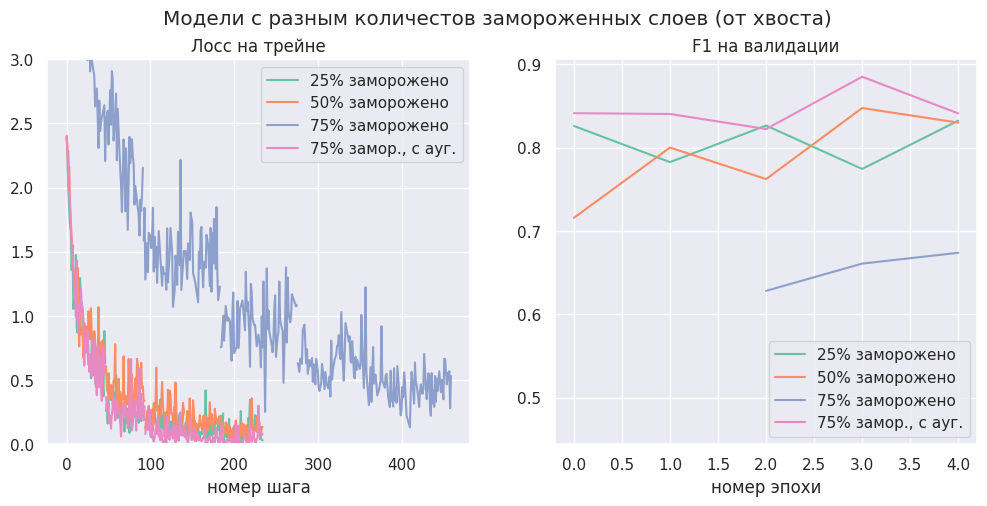

In [75]:
labels = ['25% заморожено', '50% заморожено', '75% заморожено', '75% замор., с ауг.']
plt.figure(figsize=(12, 5))
plt.suptitle('Модели с разным количестов замороженных слоев (от хвоста)')
plt.subplot(1, 2, 1)
for k, i in enumerate(frozen_ids):
    df_loss = runs[i].history()
    plt.plot(df_loss['trainer/global_step'], df_loss['train_loss'], label=labels[k])
    plt.title('Лосс на трейне')
    plt.xlabel('номер шага')
plt.ylim(0, 3)
plt.legend()

plt.subplot(1, 2, 2)
for k, i in enumerate(frozen_ids):
    df_loss = runs[i].history().groupby('epoch').mean().reset_index()
    plt.plot(df_loss['epoch'], df_loss['validation epoch F1_macro'], label=labels[k])
    plt.title('F1 на валидации')
    plt.xlabel('номер эпохи')
plt.legend()

Кажется, я тут перепутала порядок графиков...

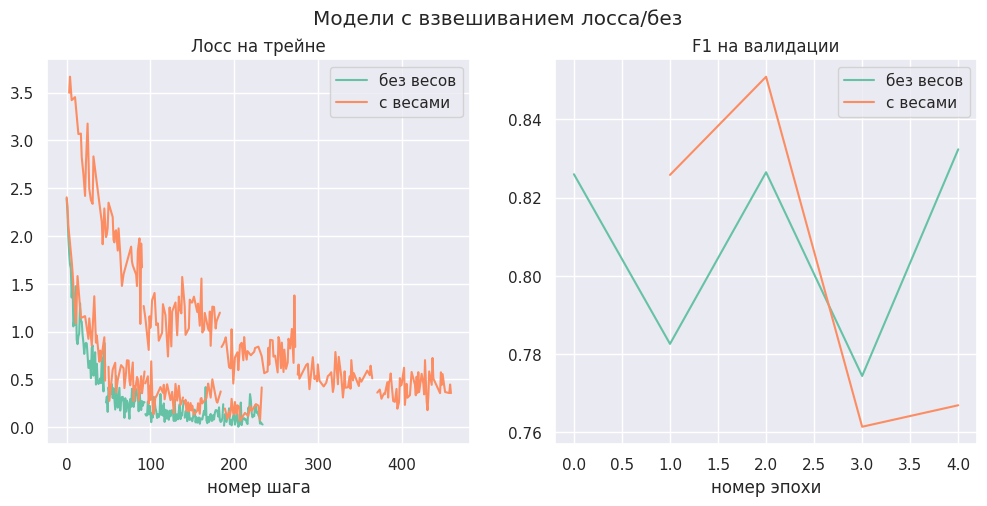

In [78]:
labels = ['без весов', 'с весами']

plt.figure(figsize=(12, 5))
plt.suptitle('Модели с взвешиванием лосса/без')
plt.subplot(1, 2, 1)
for k, i in enumerate(weights_ids):
    df_loss = runs[i].history()
    plt.plot(df_loss['trainer/global_step'], df_loss['train_loss'], label=labels[k])
    plt.title('Лосс на трейне')
    plt.xlabel('номер шага')
plt.legend()

plt.subplot(1, 2, 2)
for k, i in enumerate(weights_ids):
    df_loss = runs[i].history().groupby('epoch').mean().reset_index()
    plt.plot(df_loss['epoch'], df_loss['validation epoch F1_macro'], label=labels[k])
    plt.title('F1 на валидации')
    plt.xlabel('номер эпохи')
plt.legend()

Сделайте общий вывод по задаче.

**Вывод:**
Для обучения моделей под конкретные задачи можно использовать уже обученные модели, адаптировав их под новую задачу. Мы рассмотрели метод **Fine Tuning**, при котором дообучается финальный слой (голова) базовой модели для решения нашей задачи. Применение аугментаций данных позволяет увеличить разнообразие тренировочного набора, что способствует лучшему обучению модели и снижает вероятность переобучения. Для борьбы с дисбалансом классов можно использовать взвешивание функции потерь, увеличивая вес менее представленных классов. Это также способствует улучшению качества обучения.